In [ ]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
# to increse the accuracy we do these things
# Image size → 224
# Fine-tuning=ie-5
# Improve Data Augmentation
# LR scheduler
# increse the epoch with early stps

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras_tuner import RandomSearch
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [ ]:
! pip install opendatasets

In [ ]:

import opendatasets as od
od.download("https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf/data")

train_dir = "/content/tomatoleaf/tomato/train"
test_dir  = "/content/tomatoleaf/tomato/val"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lplipan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf


100%|██████████| 179M/179M [00:00<00:00, 970MB/s] 

In [ ]:
def create_df(data_path):
    file_path, labels = [], []
    for label in os.listdir(data_path):
        folder = os.path.join(data_path, label)
        if os.path.isdir(folder):
            for img in os.listdir(folder):
                file_path.append(os.path.join(folder, img))
                labels.append(label)
    return pd.DataFrame({'FilePath': file_path, 'Labels': labels})

train_df = create_df(train_dir)
test_df  = create_df(test_dir)

In [ ]:
# train data sample
train_df.head()

,FilePath,Labels
0,/content/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
1,/content/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
2,/content/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
3,/content/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight
4,/content/tomatoleaf/tomato/train/Tomato___Late...,Tomato___Late_blight


In [ ]:
# test data sample
test_df.head()

,FilePath,Labels
0,/content/tomatoleaf/tomato/val/Tomato___Late_b...,Tomato___Late_blight
1,/content/tomatoleaf/tomato/val/Tomato___Late_b...,Tomato___Late_blight
2,/content/tomatoleaf/tomato/val/Tomato___Late_b...,Tomato___Late_blight
3,/content/tomatoleaf/tomato/val/Tomato___Late_b...,Tomato___Late_blight
4,/content/tomatoleaf/tomato/val/Tomato___Late_b...,Tomato___Late_blight


In [ ]:
train_df.shape

(10000, 2)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='FilePath',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='FilePath',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(Conv2D(
        hp.Choice('conv1_filters', [32, 64]),
        (3,3),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 3)
    ))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.3, step=0.1)))

    model.add(Conv2D(
        hp.Choice('conv2_filters', [64, 128]),
        (3,3),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.3, step=0.1)))

    model.add(Conv2D(
        hp.Choice('conv3_filters', [128, 256]),
        (3,3),
        activation='relu',
        padding='same'
    ))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.3, step=0.1)))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(
        hp.Choice('dense_units', [128, 256]),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', 0.2, 0.3, step=0.1)))

    model.add(Dense(len(train_generator.class_indices), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='cnn_tuning',
    project_name='tomato_leaf_cnn'
)

tuner.search(
    train_generator,
    epochs=20,          # Step 7: Train longer
    validation_data=test_generator,
    callbacks=[early_stop, reduce_lr]
)

Trial 5 Complete [00h 34m 45s]
val_accuracy: 0.8970000147819519

Best val_accuracy So Far: 0.9100000262260437
Total elapsed time: 02h 30m 23s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,402 (513.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
scores = best_model.evaluate(test_generator)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9148 - loss: 0.2462
Test Loss: 0.28204768896102905
Test Accuracy: 0.9100000262260437


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Classification Report:

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.91      0.94      0.93       100
                        Tomato___Early_blight       0.83      0.91      0.87       100
                         Tomato___Late_blight       0.89      0.91      0.90       100
                           Tomato___Leaf_Mold       0.99      0.93      0.96       100
                  Tomato___Septoria_leaf_spot       0.89      0.91      0.90       100
Tomato___Spider_mites Two-spotted_spider_mite       0.88      0.91      0.90       100
                         Tomato___Target_Spot       0.96      0.76      0.85       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.91      0.99      0.95       100
                 Tomato___Tomato_mosaic_virus       1.00      0.85      0.92       100
                             Tomato___healthy       0.88      0.

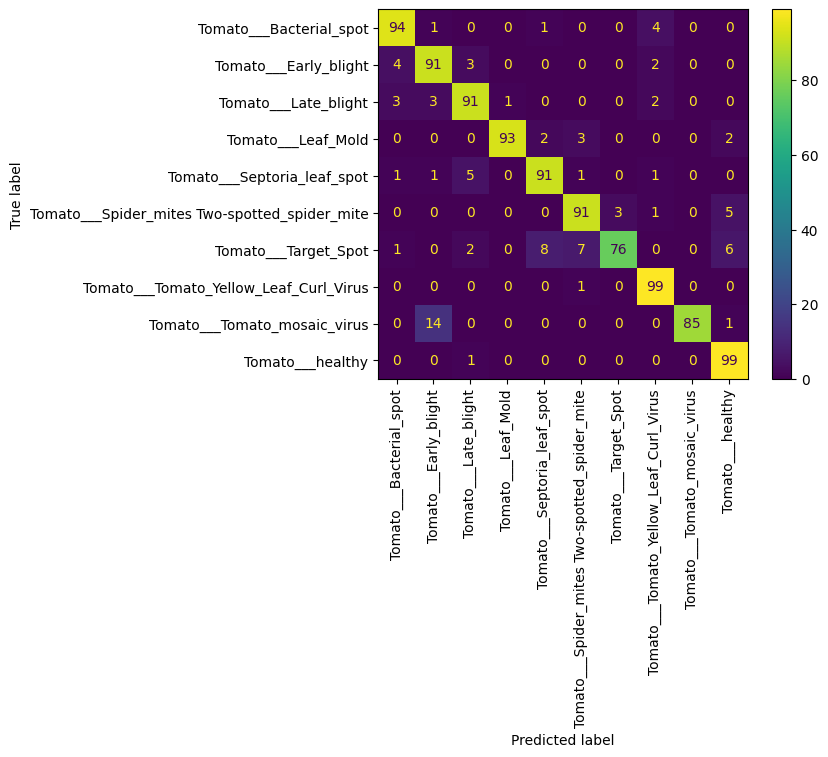

In [ ]:
y_pred = best_model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)
true_class = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

ConfusionMatrixDisplay.from_predictions(
    true_class,
    y_pred_class,
    display_labels=class_labels,
    xticks_rotation=90
)

print("\nClassification Report:\n")
print(classification_report(true_class, y_pred_class, target_names=class_labels))

In [ ]:
# Save model in HDF5 format (recommended)
best_model.save("cnn_model.h5")



In [ ]:
from google.colab import files
files.download("cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>